In [1]:
from transformers import AutoFeatureExtractor, DeiTForImageClassificationWithTeacher
from PIL import Image
import requests
import torch
from torch import nn
from torch import Tensor
from einops.layers.torch import Rearrange


from einops.layers.torch import Rearrange



url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)


/home/newt/miniconda3/envs/ds/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:

class RaViTTPatchEmbedding(nn.Module):
    def __init__(self, proj: nn.Module, norm: nn.Module, patch_size: int = 16, img_size: int = 224, isFull: bool = False, npatches: int = 192):
        super().__init__()
        self.patch_size = patch_size
        self.img_size = img_size
        self.proj = proj
        self.norm = norm
        self.isFull = isFull
        self.npatches = npatches
        self.rearr = Rearrange('b (lh lw) c ph pw -> b c (lh ph) (lw pw)', lh=(img_size//patch_size), lw=(img_size//patch_size), ph=patch_size, pw=patch_size)
        if isFull:
            self.rearr = Rearrange('b (lh lw) c ph pw -> b c (lh ph) (lw pw)', lh=1, lw=npatches, ph=patch_size, pw=patch_size)
        #base_grid0 = torch.arange(0, crop_size, device=input_batch.device).view(1, 1, -1).repeat(npatches, crop_size, 1)
        #base_grid1 = torch.arange(0, crop_size, device=input_batch.device).view(1, -1, 1).repeat(npatches, 1, crop_size)

    def overlap_positional_encoding(self, batch_size, patches, embedded_dim, positions):

        if embedded_dim % 4 != 0:
            raise ValueError("Cannot use sin/cos positional encoding with "
                            "odd dimension (got dim={:d})".format(embedded_dim))
        sqrt_p = patches**0.5
        dev = positions.device
        if (sqrt_p).is_integer():
            npatches_h = int(sqrt_p)
            npatches_w = npatches_h
        else:
            npatches_h = (patches//2)
            npatches_w = 2
        pe = torch.zeros(batch_size, npatches_h, npatches_w, embedded_dim, device=dev)

        # Each dimension use half of embedded_dim
        d_embed = embedded_dim
        embedded_dim = d_embed // 2

        den = (10000 ** (2 * torch.arange(0, embedded_dim//2, device=dev) / d_embed)).repeat(batch_size, 1,1,1)

        pos_h = positions[:, :, 0].reshape(batch_size, npatches_h, npatches_w).unsqueeze(-1).repeat(1,1,1,embedded_dim//2)
        pos_w = positions[:, :, 1].reshape(batch_size, npatches_h, npatches_w).unsqueeze(-1).repeat(1,1,1,embedded_dim//2)

        pe[:, :, :, 0:embedded_dim:2] = torch.sin(pos_h / den)
        pe[:, :, :, 1:embedded_dim:2] = torch.cos(pos_h / den)
        pe[:, :, :, embedded_dim::2] = torch.sin(pos_w /  den)
        pe[:, :, :, embedded_dim + 1::2] = torch.cos(pos_w / den)

        return pe.reshape(batch_size, patches, d_embed)


    def random_patch_extraction(self, input_batch, crop_size:int):
        batch_size, npatches, _, height, width = input_batch.shape
        n= height//crop_size
        
        # Generate random crop coordinates for each image in the batch
        crop_top = torch.randint(0, height - crop_size + 1, (npatches,), device=input_batch.device)
        crop_left = torch.randint(0, width - crop_size + 1, (npatches,), device=input_batch.device)
        #crop_top = torch.arange(n).unsqueeze(1).repeat(1,n).view(-1)*crop_size
        #crop_left = torch.arange(n).repeat(n)*crop_size
        # Create a grid of coordinates for each image in the batch
        grid = torch.zeros((npatches, crop_size, crop_size, 2), device=input_batch.device)
        grid[:, :, :, 0] = torch.arange(0, crop_size, device=input_batch.device).view(1, 1, -1).repeat(npatches, crop_size, 1)
        grid[:, :, :, 1] = torch.arange(0, crop_size, device=input_batch.device).view(1, -1, 1).repeat(npatches, 1, crop_size)

        # Add the crop coordinates to the grid
        grid[:, :, :, 0] += crop_left.view(-1, 1, 1) 
        grid[:, :, :, 1] += crop_top.view(-1, 1, 1)

        grid[:, :, :, 0] = 2*(grid[:, :, :, 0])/width -1 
        grid[:, :, :, 1] = 2*(grid[:, :, :, 1])/height -1 
        
        #create an empty tensor to accumulate the crops
        crops_positions = torch.stack((crop_top/crop_size, crop_left/crop_size), dim=1)
        output_batch = torch.zeros((batch_size, npatches, 3, crop_size, crop_size), device=input_batch.device)
        for i in range(batch_size):
            output_batch[i] = (torch.nn.functional.grid_sample(input_batch[i], grid, align_corners=True))
        return output_batch, crops_positions.expand(batch_size, npatches, 2)

    def ramdomizedPatchExtraction(self, batch, patch_size:int = 16, npatches :int = 192):
        x = batch.unsqueeze(1).expand(-1, npatches, -1, -1, -1)
        x, pos = self.random_patch_extraction(x, crop_size=patch_size)
        return self.rearr(x), pos
        #return x, pos

    def forward(self, x):
        if self.isFull:
            x, pos = self.ramdomizedPatchExtraction(x, patch_size=self.patch_size, npatches=self.npatches)
        else:
            x, pos = self.ramdomizedPatchExtraction(x, patch_size=self.patch_size, npatches=(self.img_size//self.patch_size)**2)
        x = self.proj(x.to())
        x = x.flatten(2).transpose(1, 2)  # NCHW -> NLC
        x = self.norm(x)

        return x, pos

In [27]:
from timm.models import create_model

path = 'facebook/deit_tiny_patch16_224'
model =  create_model(path, pretrained=True)

rav = RaViTTPatchEmbedding(model.patch_embed.proj, model.patch_embed.norm, patch_size=16, img_size=224, isFull=True, npatches=192//2)

In [28]:
#create transform ToTensor() from torchvision
import torchvision.transforms as transforms
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224))])


image_tensor = transform(image).unsqueeze(0)
print(image_tensor.shape)

torch.Size([1, 3, 224, 224])


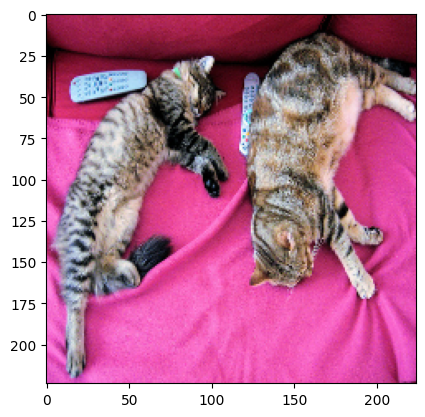

In [29]:
#show image
import matplotlib.pyplot as plt
plt.imshow(image_tensor.squeeze(0).permute(1,2,0))

In [30]:
output_rav = rav(image_tensor)
print(output_rav[0].shape, output_rav[1].shape)

torch.Size([1, 96, 192]) torch.Size([1, 96, 2])


In [31]:
#print the output image
#chage figsize
plt.figure(figsize=(60,20))
plt.imshow(output_rav[0].squeeze(0).permute(1,2,0).mean(2))

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

<Figure size 6000x2000 with 0 Axes>

In [ ]:
def interlaced(x, x_rv, t):
    mask = torch.rand((x.shape[1],), device=x.device) < t
    mask = mask.to(x.dtype).unsqueeze(0).unsqueeze(2).expand(x.shape[0], -1, -1)
    return x_rv * mask +  x*(1-mask)
def new_forward(self, x):
	x_og = self.patch_embed(x) #embed vit
	x_og = self._pos_embed(x_og) #add positional encoding vit

	if self.training:
		x_rv, pos = self.ravitt(x) #embed ravitt
		x_rv = x_rv + self.ravitt.overlap_positional_encoding(x_rv.shape[0], x_rv.shape[1], x_rv.shape[2], pos) #add positional encoding ravitt
		slice_to_append = x_og[:, 0, :].unsqueeze(1)  # Shape will be (256, 1, 128)

		x_rv = torch.cat((slice_to_append, x_rv), dim=1)
		x = self.ravitt_func(x_og, x_rv)
	else:
		x = x_og


	x = self.norm_pre(x)
	if self.grad_checkpointing and not torch.jit.is_scripting():
		x = self.checkpoint_seq(self.blocks, x)
	else:
		x = self.blocks(x)
	x = self.norm(x)
	x = self.forward_head(x)
	return x
def create_model_wrapper(path, ravitt_t=0.0, ravitt_mode='none', **kwargs):
    model =  create_model(path, **kwargs)
    if ravitt_mode == 'none':
        return model
    if ravitt_mode == 'full':
        model.ravitt = RaViTTPatchEmbedding(model.patch_embed.proj, model.patch_embed.norm, patch_size=16, img_size=224, isFull=True, npatches=int(192*ravitt_t))
    else:  
        model.ravitt = RaViTTPatchEmbedding(model.patch_embed.proj, model.patch_embed.norm, patch_size=16, img_size=224)
    t = ravitt_t
    model.t = t
    if ravitt_mode == 'interlaced':
        model.ravitt_func = lambda x, x_rv: interlaced(x, x_rv, t)
    elif ravitt_mode == 'avg':
        model.ravitt_func = lambda x, x_rv: x*(1-t) + x_rv*t
    elif ravitt_mode == 'choice':
        model.ravitt_func = lambda x, x_rv: x_rv if torch.rand(1) < t else x
    elif ravitt_mode == 'full':
        model.ravitt_func = lambda x, x_rv: x_rv
    else:
        raise ValueError(f'Unknown ravitt mode {ravitt_mode}')
    model.forward = new_forward.__get__(model, VisionTransformer)
    return model
model = create_model_wrapper(path, ravitt_t=0.5, ravitt_mode='full', pretrained=True)   